# Dynamic rupture modeling of gouge patch: search best fit parameter

In this notebook, we compute the best-fit source parameter obtained in the `aux01_compute_M0andSTF_paramstudy.py`.

2025.2.3 Kurama Okubo


In [29]:
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import timedelta
from tqdm import tqdm
import warnings
import time
from datetime import datetime

import pickle

from scipy.optimize import minimize

from scipy.signal import freqz
from scipy import signal

import h5py
import seaborn as sns

from post_dynrup_func import *

%load_ext autoreload
%autoreload 2

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 10
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = False

plt.rcParams['axes.linewidth'] = 0.75

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
figdir = "../figure/aux01_paramstudy"
if not os.path.exists(figdir):
    os.makedirs(figdir)

In [31]:
datadir = "../data/aux01_paramstudy"
if not os.path.exists(datadir):
    os.makedirs(datadir)

# Read the parameter datasheet

In [32]:
E = 96e9
nu = 0.246 # metagabbro
mu = E/(2*(1+nu))

a_patch = 4.0e-3
rupturetype = "pulse"
pdcscaling= 0.6 #0.54 #0.475 #0.5 #0.55 # 0.65
bgbeta= 0.35 #0.4 #0.3 #0.5
# gammautry = 0.8

nb_x_elements = 1024 #128
nb_z_elements = 1024 #128

sig_n = 6e6

IfBinaryOutput = True

read_dumpedpickle = False # false if you first run the notebook

In [33]:
# case study parameter casename
casestr = f"a={a_patch*1e3:.2f}_ruptype={rupturetype}_pdcscaling={pdcscaling:.3f}_sn={sig_n/1e6:.1f}MPa_hatfr=0.3_bgbeta={bgbeta:.2f}"

# finame=f"../../preprocess_modelsetup/data/gouge_dynamicrupture_modelparam_{casestr}.csv"

# # Read model parameters
# df_modelparam = pd.read_csv(finame, index_col=0)

# # datadir_root = "../../../uguca/build_v42_masterfitmodel/simulations_main_casestudy"

# # datadir_root = "/Volumes/4mGouge_WorkHDD/RuptureSimulation/build_hpcv15_neweventset_dt1e-8/simulations_main_casestudy_hpc"
# datadir_root = "/Volumes/4mGouge_WorkHDD/RuptureSimulation/build_hpcv44_paramstudy_v2/simulations_main_casestudy_hpc_dev"

# casestr

In [34]:
df_paramstudy_all = pd.read_csv(f"../data/aux01_dynrup_paramstudy_{casestr}.csv")


In [35]:
df_paramstudy_all.head()

,model_id,delsigma_factor,M0_obs,Tw_obs,M0_model,Tw_model
0,24,0.680,0.065804,0.000002,0.064212,0.000002
1,24,0.685,0.065804,0.000002,0.065057,0.000002
2,24,0.690,0.065804,0.000002,0.065934,0.000002
3,24,0.695,0.065804,0.000002,0.066707,0.000002
4,24,0.700,0.065804,0.000002,0.067559,0.000002


# Compute residuals

We compute the residuals associated with the source parameters as follows:
<!-- $$ res = \dfrac{(M_0^{obs} - M_0^{model})^2}{M_0^{obs~2}} +  \dfrac{(T_w^{obs} - T_w^{model})^2}{T_w^{obs~2}} $$ -->
$$ res = \dfrac{(M_0^{obs} - M_0^{model})^2}{\sigma_{M_0}^{model~2}} +  \dfrac{(T_w^{obs} - T_w^{model})^2}{\sigma_{T_w}^{model~2}} $$

In [36]:
# Read event catalog to get the std of observation

In [37]:
df_events = pd.read_csv("../../../../GougeEventCatalog/data/gougeeventcatalog__fb03-087__G3__Q50.csv", index_col=0)
df_events.head()

,location,event_onset_time,stickslip_id,event_label,Q_correction_quart,Nvalidsensors,M0,M0_std,Mw,Tw,Tw_std
event_id,,,,,,,,,,,
4,1.75,42.474772,3,A,50,4,0.594031,0.179160,-6.217460,0.000003,1.516442e-07
9,1.75,47.662693,5,F,50,4,0.047135,0.007497,-6.951102,0.000002,3.630314e-07
18,1.75,56.727044,8,F,50,4,0.757592,0.193624,-6.147043,0.000003,3.109912e-07
19,1.75,59.103175,9,F,50,4,0.056071,0.017249,-6.900839,0.000002,2.699614e-07
20,1.75,59.103526,9,F,50,4,0.867075,0.209970,-6.107962,0.000003,1.379112e-07


In [38]:
selectids_list = [24, 50, 52, 72, 129]

In [39]:
def compute_res(M0_obs, Tw_obs, M0_model, Tw_model, sig_M0, sig_Tw):
    print(f"M0 term:{(M0_obs-M0_model)**2/sig_M0**2:.3e},  Tw term:{(Tw_obs-Tw_model)**2/sig_Tw**2:.4e}")
    print(f"Tw debug:{ (Tw_obs-Tw_model)**2:.4e}, {sig_Tw**2 }")
    return (M0_obs-M0_model)**2/sig_M0**2 + (Tw_obs-Tw_model)**2/sig_Tw**2 

In [40]:
# compute the variance of model source parameters
for model_id in selectids_list:
    df_case = df_paramstudy_all[df_paramstudy_all["model_id"] == model_id]
    if len(df_case) == 1:
        M0_model_var = 1e-3*df_case["M0_model"] # dummy number
        Tw_model_var = 1e-9*df_case["Tw_model"] # dummy number
    else:
        M0_model_var = np.var(df_case["M0_model"], ddof=1)
        Tw_model_var = np.var(df_case["Tw_model"], ddof=1)
        
    df_paramstudy_all.loc[df_paramstudy_all["model_id"]==model_id, "M0_std"] = np.sqrt(M0_model_var)
    df_paramstudy_all.loc[df_paramstudy_all["model_id"]==model_id, "Tw_std"] = np.sqrt(Tw_model_var)

    # df_paramstudy_all.loc[df_paramstudy_all["model_id"]==model_id, "M0_std"] = df_events.loc[model_id, "M0_std"]
    # df_paramstudy_all.loc[df_paramstudy_all["model_id"]==model_id, "Tw_std"] = df_events.loc[model_id, "Tw_std"]
    

In [41]:
df_paramstudy_all["res"] = df_paramstudy_all.apply(lambda x: compute_res(x["M0_obs"], x["Tw_obs"], x["M0_model"], x["Tw_model"], x["M0_std"],  x["Tw_std"]), axis=1)

M0 term:5.021e-01,  Tw term:3.0460e+00
Tw debug:6.5602e-16, 2.1537402585111046e-16
M0 term:1.106e-01,  Tw term:1.7875e+00
Tw debug:3.8498e-16, 2.1537402585111046e-16
M0 term:3.336e-03,  Tw term:1.2751e+00
Tw debug:2.7461e-16, 2.1537402585111046e-16
M0 term:1.613e-01,  Tw term:2.6114e-01
Tw debug:5.6243e-17, 2.1537402585111046e-16
M0 term:6.099e-01,  Tw term:5.9378e-02
Tw debug:1.2788e-17, 2.1537402585111046e-16
M0 term:1.332e+00,  Tw term:9.1202e-04
Tw debug:1.9643e-19, 2.1537402585111046e-16
M0 term:2.254e+00,  Tw term:2.4681e-01
Tw debug:5.3156e-17, 2.1537402585111046e-16
M0 term:3.448e+00,  Tw term:7.2038e-01
Tw debug:1.5515e-16, 2.1537402585111046e-16
M0 term:4.912e+00,  Tw term:1.2757e+00
Tw debug:2.7476e-16, 2.1537402585111046e-16
M0 term:4.440e+00,  Tw term:1.8142e-01
Tw debug:1.6319e-17, 8.995020118516697e-17
M0 term:3.615e+00,  Tw term:2.2096e-02
Tw debug:1.9875e-18, 8.995020118516697e-17
M0 term:2.872e+00,  Tw term:2.7792e-02
Tw debug:2.4999e-18, 8.995020118516697e-17
M0 term

In [42]:
df_paramstudy_all

,model_id,delsigma_factor,M0_obs,Tw_obs,M0_model,Tw_model,M0_std,Tw_std,res
0,24,0.680,0.065804,0.000002,0.064212,0.000002,0.002247,1.467563e-08,3.548033
1,24,0.685,0.065804,0.000002,0.065057,0.000002,0.002247,1.467563e-08,1.898101
2,24,0.690,0.065804,0.000002,0.065934,0.000002,0.002247,1.467563e-08,1.278395
3,24,0.695,0.065804,0.000002,0.066707,0.000002,0.002247,1.467563e-08,0.422411
4,24,0.700,0.065804,0.000002,0.067559,0.000002,0.002247,1.467563e-08,0.669237
5,24,0.705,0.065804,0.000002,0.068398,0.000002,0.002247,1.467563e-08,1.333227
6,24,0.710,0.065804,0.000002,0.069178,0.000002,0.002247,1.467563e-08,2.500626
7,24,0.715,0.065804,0.000002,0.069977,0.000002,0.002247,1.467563e-08,4.167917
8,24,0.720,0.065804,0.000002,0.070785,0.000002,0.002247,1.467563e-08,6.187479
9,50,0.465,0.327197,0.000003,0.282319,0.000003,0.021297,9.484208e-09,4.621771


In [43]:
selectids_list = [24, 50, 52, 72, 129]
# selectids_list = [50] #72, 129]


In [44]:
fo = open(datadir+f"/paramsearch_minres_{casestr}.txt", "w")

for model_id in selectids_list:
    df_case = df_paramstudy_all[df_paramstudy_all["model_id"] == model_id]

    # find the minimum residual case
    df_min = df_case.sort_values(by="res").iloc[0]
    minvalue = f"{model_id}, {df_min['delsigma_factor']:.04f}, {df_min['res']:.3g}"
    print(minvalue)
    fo.write(minvalue+"\n")

fo.close()

24, 0.6950, 0.422
50, 0.4950, 1.32
52, 0.4600, 1.49
72, 0.4300, 0.422
129, 0.4100, 0.411


# Plot result

In [45]:
# load color dictionary consistent to the plot of the repeated waveforms
repeated_sensor_lcdict = "OL08" # the color dict is same for all the sensor although separately saved.
gougepatch_id = "G3"
with open(f'../../../../ComputeScaling/data/01_plot_gougeevents/lc_dict_{gougepatch_id}_{repeated_sensor_lcdict}.pkl', 'rb') as fi:
    lc_dict = pickle.load(fi)

In [46]:
# lc_dict

In [47]:
# selectids_list=[24]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


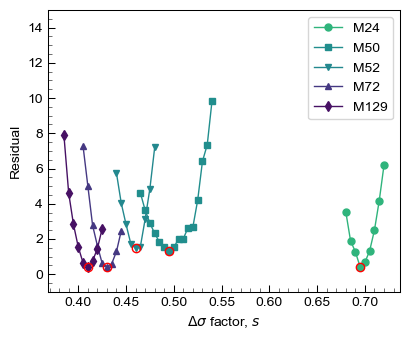

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(4.2, 3.5))

markers=["o", "s", "v", "^", "d"]
for ii, model_id in enumerate(selectids_list):
    df_case = df_paramstudy_all[df_paramstudy_all["model_id"] == model_id]

    ax.plot(df_case["delsigma_factor"], df_case["res"], marker=markers[ii], c=lc_dict[f"fb03-087__{model_id:04d}"],
            label=f"M{model_id}", lw=1, ms=5)

    df_min = df_case.sort_values(by="res").iloc[0]
    ax.plot(df_min["delsigma_factor"], df_min["res"], marker="o", c="r", mfc="None", label="")


ax.set_xlabel(r"$\Delta \sigma$ factor, $s$")
ax.set_ylabel("Residual")
# ax.set_xlim([0.35, 0.55])
ax.set_ylim([-1, 15])
ax.legend(loc=1)

plt.tight_layout()

plt.savefig(figdir+f"/paramsearch_{casestr}.png",  dpi=100)
plt.savefig(figdir+f"/paramsearch_{casestr}.eps")


In [49]:
# df_case

In [50]:
# df_paramstudy_all